In [1]:
!git clone https://github.com/Oliverluyu/brain_tumor_img_segmentation.git
%cd brain_tumor_img_segmentation
!git checkout experiment2


Cloning into 'brain_tumor_img_segmentation'...
remote: Enumerating objects: 13199, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 13199 (delta 21), reused 45 (delta 18), pack-reused 13149
Receiving objects: 100% (13199/13199), 553.91 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (575/575), done.
Updating files: 100% (15653/15653), done.
/content/brain_tumor_img_segmentation
Branch 'experiment2' set up to track remote branch 'experiment2' from 'origin'.
Switched to a new branch 'experiment2'


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from models.network_helper import init_weights
import torchvision.transforms as transforms
import torch.optim as optim
from models.VanillaUnet import unet_2D
import matplotlib.pyplot as plt

In [3]:
import torch
import numpy as np
import random
import os

def set_random_seed(seed_value):
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [5]:
#define dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        self.image_paths = self._get_paths(self.image_dir)
        self.mask_paths = self._get_paths(self.mask_dir)

    def _get_paths(self, directory):
        paths = []
        for subdir in os.listdir(directory):
            subdir_path = os.path.join(directory, subdir)
            if os.path.isdir(subdir_path):
                for filename in os.listdir(subdir_path):
                    paths.append(os.path.join(subdir_path, filename))
        return paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # image = Image.open(img_path).convert('L')  # Keep as grayscale
        # mask = Image.open(mask_path).convert('L')  # Keep as grayscale
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

In [13]:
# Function to create train and test data loaders
def create_data_loaders(dataset_path, batch_size=4):

    # Define transforms
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
    ])

    # Initialize dataset and dataloaders
    train_dataset = BrainTumorDataset(root_dir=f'{dataset_path}train',
                                    transform=transform)
    test_dataset = BrainTumorDataset(root_dir=f'{dataset_path}test',
                                    transform=transform)
    val_dataset = BrainTumorDataset(root_dir=f'{dataset_path}validation',
                                transform=transform)
    # # Initialize dataset and dataloaders
    # train_dataset = BrainTumorDataset(root_dir='datasets/segmentation/train',
    #                                 transform=transform)
    # test_dataset = BrainTumorDataset(root_dir='datasets/segmentation/test',
    #                                 transform=transform)
    # val_dataset = BrainTumorDataset(root_dir='datasets/segmentation/validation',
    #                             transform=transform)

    # Define dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [14]:
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, saved_model='transfer_learning.pth'):
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        training_losses.append(epoch_loss)


        # Validation loop
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, masks)
                val_running_loss += val_loss.item() * images.size(0)


        # Calculate and store average metrics for the epoch
        val_epoch_loss = val_running_loss / len(val_loader)
        validation_losses.append(val_epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # After the training loop, plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    model_save_path = f'saved_models/{saved_model}'
    os.makedirs('saved_models', exist_ok=True)
    torch.save(model.state_dict(), model_save_path)

### no Transfer learning.

Epoch 1/20, Training Loss: 0.3537, Validation Loss: 5.2541
Epoch 2/20, Training Loss: 0.1525, Validation Loss: 2.6792
Epoch 3/20, Training Loss: 0.0786, Validation Loss: 1.4459
Epoch 4/20, Training Loss: 0.0503, Validation Loss: 1.0068
Epoch 5/20, Training Loss: 0.0373, Validation Loss: 0.8262
Epoch 6/20, Training Loss: 0.0292, Validation Loss: 0.6591
Epoch 7/20, Training Loss: 0.0245, Validation Loss: 0.6803
Epoch 8/20, Training Loss: 0.0212, Validation Loss: 0.5037
Epoch 9/20, Training Loss: 0.0181, Validation Loss: 0.4792
Epoch 10/20, Training Loss: 0.0162, Validation Loss: 0.4369
Epoch 11/20, Training Loss: 0.0148, Validation Loss: 0.4571
Epoch 12/20, Training Loss: 0.0131, Validation Loss: 0.4030
Epoch 13/20, Training Loss: 0.0120, Validation Loss: 0.4685
Epoch 14/20, Training Loss: 0.0110, Validation Loss: 0.3746
Epoch 15/20, Training Loss: 0.0096, Validation Loss: 0.4197
Epoch 16/20, Training Loss: 0.0095, Validation Loss: 0.3583
Epoch 17/20, Training Loss: 0.0083, Validation Lo

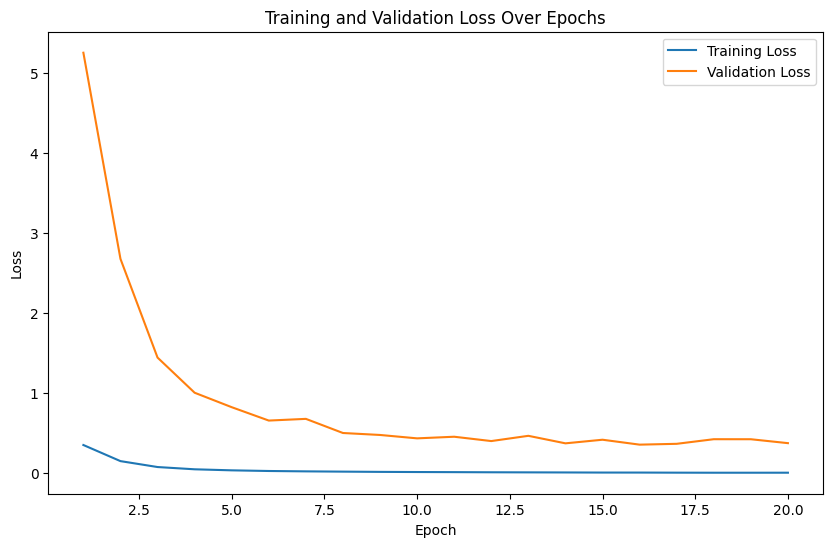

In [25]:
## try with no transfer learning
# Set random seeds to ensure repeatability
set_random_seed(42)

dataset_path = 'datasets/segmentation/'

# Create data loaders
# train_loader, val_loader, test_loader = create_data_loaders(dataset_path, batch_size=4) # DOE 1
train_loader, val_loader, test_loader = create_data_loaders(dataset_path, batch_size=24)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

# Proceed with the setup for training, such as defining loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss for binary segmentation  # DOE 2
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20 #fixed to 20 epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_unet(model, train_loader, val_loader, criterion, optimizer, \
           num_epochs, saved_model='transfer_learning_batch24_notf.pth')

In [26]:
# test
dataset_path = 'datasets/segmentation/'

# Create data loaders
# train_loader, val_loader, test_loader = create_data_loaders(dataset_path, batch_size=4) # DOE 1
train_loader, val_loader, test_loader = create_data_loaders(dataset_path, batch_size=24)

# Define VanillaUnet model for segmentation
model = unet_2D(in_channels=1, mode='segmentation')  # Assuming segmentation task setup

trained_model = 'transfer_learning_batch24_notf.pth'

# load state
model_state = torch.load( f'saved_models/{trained_model}', \
                         map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

model.load_state_dict(model_state)

# move to CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.eval()


unet_2D(
  (conv1): UnetConv(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): UnetConv(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

Average IoU for the test set: 0.6312
Average F1 Score for the test set: 0.7315
Test Loss: 0.11524776617685954


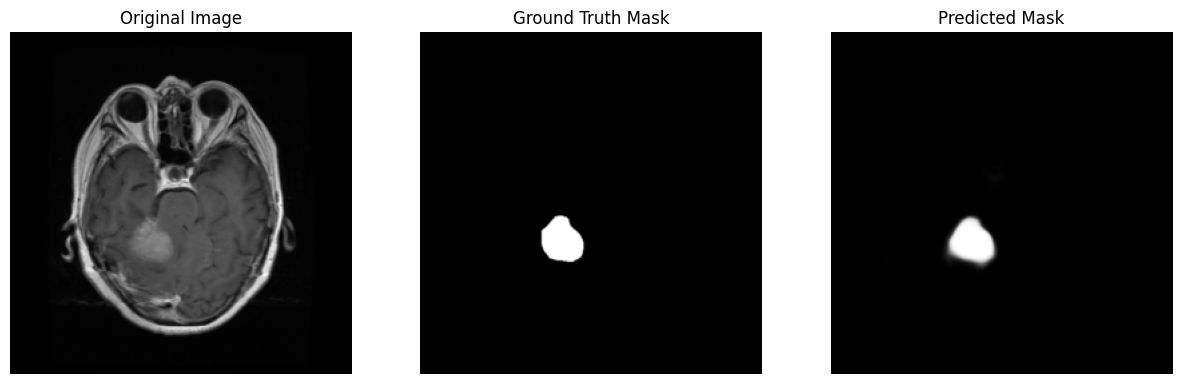

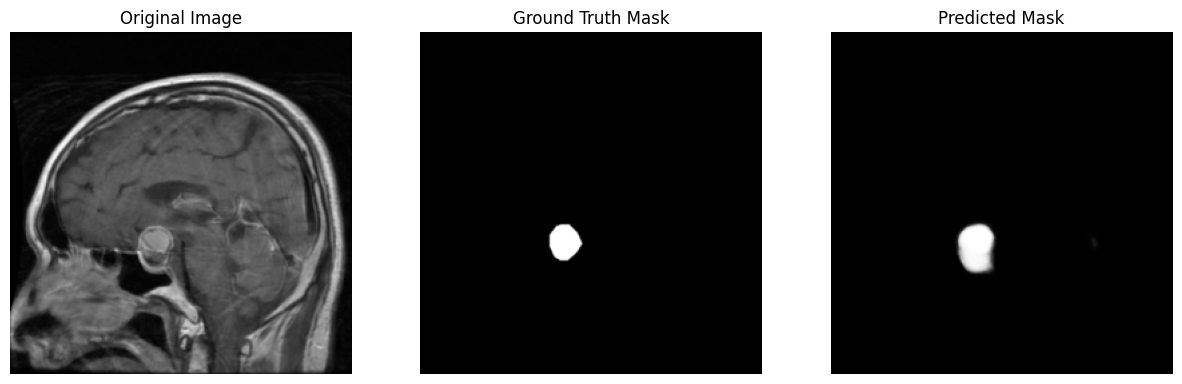

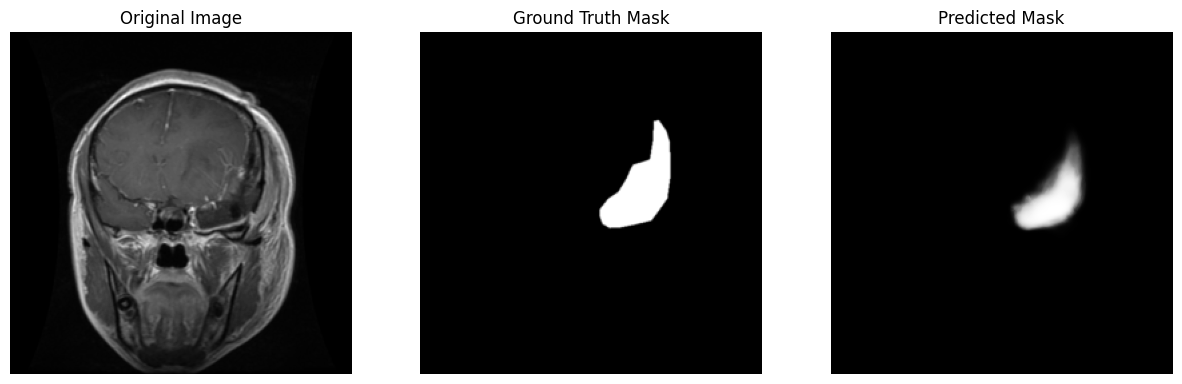

In [27]:
# Variables for IoU and F1 score calculations
iou_scores = []
f1_scores = []
num_images_to_visualize = 3
visualized_count = 0

# Variables for loss calculation
total_loss = 0.0

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        # Move images and masks to device
        images = images.to(device)
        masks = masks.to(device)

        # Get model predictions and apply sigmoid to get probabilities
        predictions = torch.sigmoid(model(images))

        # Calculate IoU and F1 for each image in the batch and accumulate
        for img, msk, pred in zip(images, masks, predictions):
            iou = calculate_iou(pred, msk)
            f1 = calculate_f1_score(pred, msk)
            iou_scores.append(iou)
            f1_scores.append(f1)

        # Calculate loss for the batch and accumulate
        loss = criterion(predictions, masks)
        total_loss += loss.item()

        # Visualize the first few images, masks, and predictions
        if visualized_count < num_images_to_visualize:
            visualize_images(images[0], masks[0], predictions[0])
            visualized_count += 1

        # Break the loop if we have visualized the required number of images
        if visualized_count >= num_images_to_visualize:
            break

# Calculate and print the average IoU, F1 score, and loss
average_iou = sum(iou_scores) / len(iou_scores)
average_f1 = sum(f1_scores) / len(f1_scores)
test_loss = total_loss / len(test_loader)

print(f"Average IoU for the test set: {average_iou:.4f}")
print(f"Average F1 Score for the test set: {average_f1:.4f}")
print(f"Test Loss: {test_loss}")

